

Beam Definition: LG_0^1 beam (λ=1550nm, w0=25.0mm, z_R=633.386m, M²=2)
Ideal Divergence (θ₀): 19.74 µrad
Effective Divergence (Θ): 39.47 µrad
Fundamental Rayleigh Range (z₀): 1266.77 m

Params at z=z_R (633.4m):
  w(z_R) = 35.36 mm
  R(z_R) = 1266.77 m

Propagation Summary for LG_0^1 beam:
Distance (m) | w(z) (mm) | R(z) (m) | Gouy Phase (rad) | w(z)/w0
-----------------------------------------------------------------
     0.0   |   25.00   |        ∞ |       0.000    | 1.00
   633.4   |   35.36   |  1266.77 |       0.927    | 1.41
  1266.8   |   55.90   |  1583.46 |       1.571    | 2.24
  1900.2   |   79.06   |  2111.29 |       1.966    | 3.16
  1000.0   |   46.72   |  1401.18 |       1.336    | 1.87
  1200.0   |   53.56   |  1534.31 |       1.517    | 2.14

Transmitter Configuration:
  Power: 2.0 W (33.0 dBm)
  Laser Linewidth: 10.0 kHz
    → Phase Noise RMS: 0.454 deg
  Timing Jitter: 5.0 ps RMS
    → Phase Error RMS: 967.74 cycles (348387.1 deg)
  TX Aperture: 50.0 mm radius
   

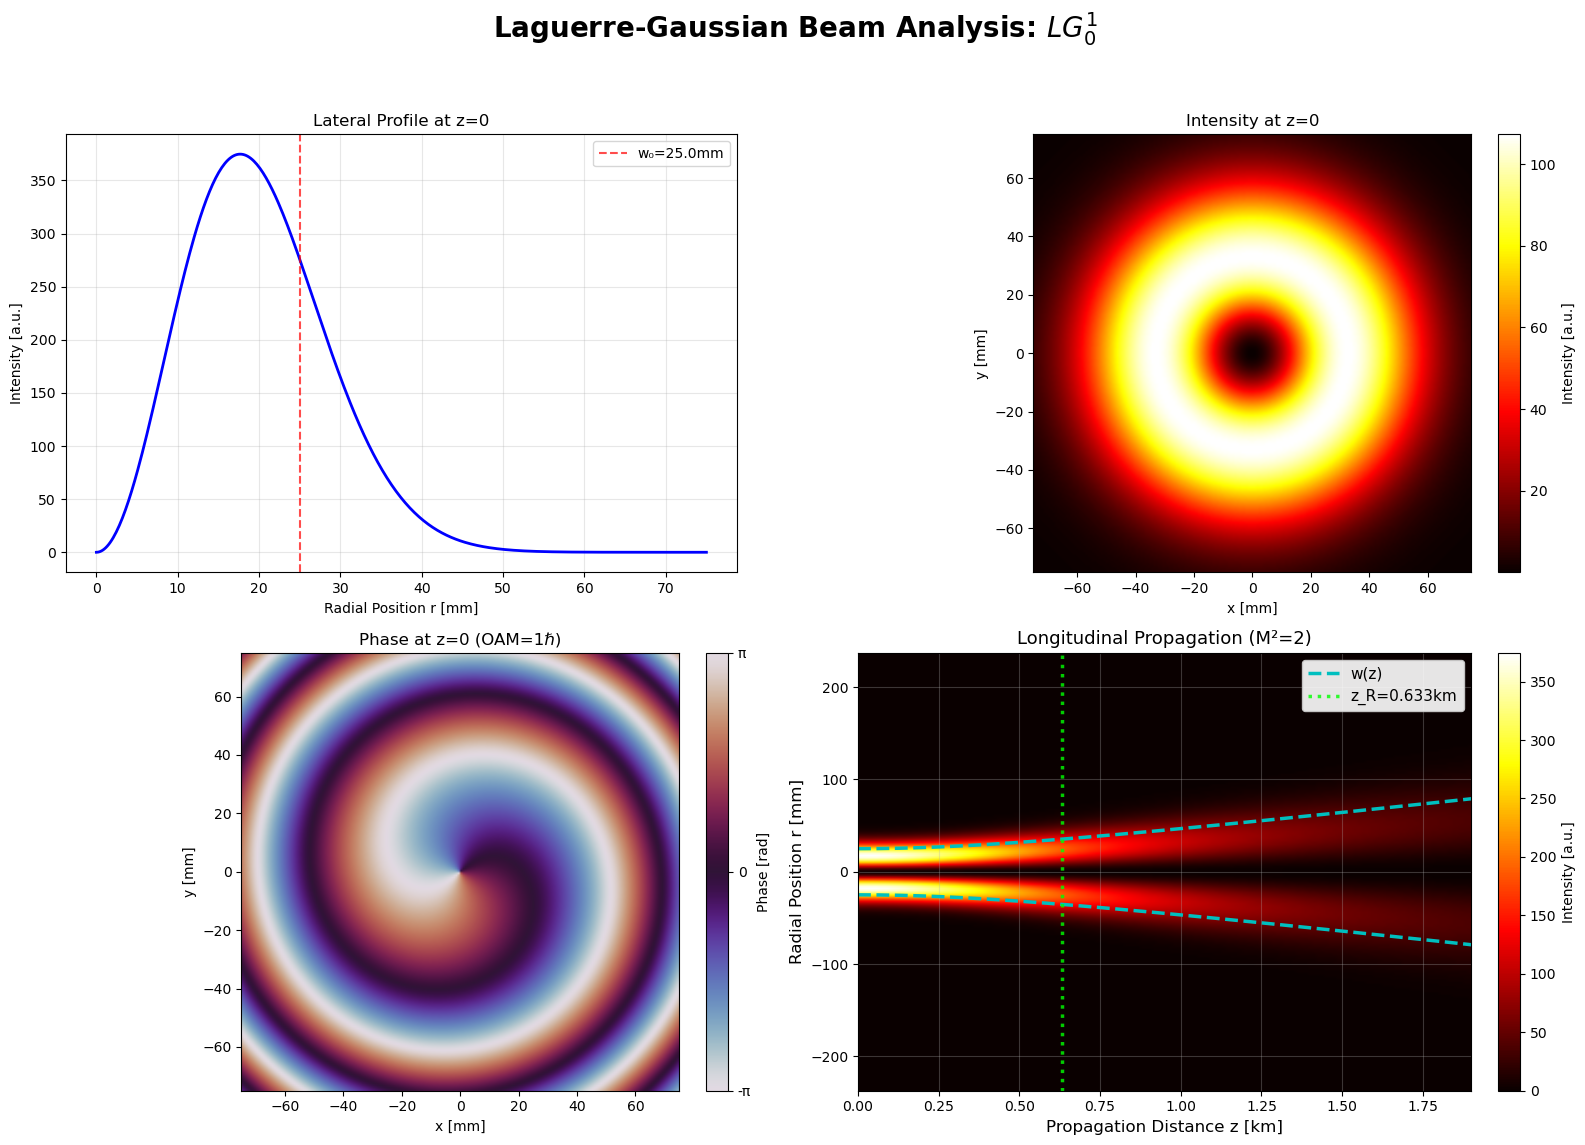

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial, eval_genlaguerre
import os

_trapezoid = getattr(np, "trapezoid", np.trapz)

class LaguerreGaussianBeam:
    def __init__(self, p, l, wavelength, w0):

        if p < 0:
            raise ValueError(f"Radial index p must be non-negative, got p={p}")
        
        self.p = p
        self.l = l
        self.wavelength = wavelength
        self.w0 = w0 
        self.k = 2 * np.pi / wavelength
        self.M_squared = 2 * p + abs(l) + 1
        self.z0_fundamental = (np.pi * w0**2) / wavelength
        self.z_R = self.z0_fundamental / self.M_squared
        self.C_norm = np.sqrt(2.0 * factorial(p) / (np.pi * factorial(p + abs(l))))

    def beam_waist(self, z):
        return self.w0 * np.sqrt(1 + ((self.M_squared * z / self.z0_fundamental) ** 2))

    def radius_of_curvature(self, z):
        z = np.asarray(z)
        R_z = np.full_like(z, np.inf, dtype=float)
        nonzero_mask = np.abs(z) >= 1e-12
        R_z[nonzero_mask] = z[nonzero_mask] * (1 + (self.z_R / z[nonzero_mask]) ** 2)
        if np.ndim(z) == 0:
            return float(R_z)
        return R_z

    def gouy_phase(self, z):
        return self.M_squared * np.arctan(z / self.z0_fundamental)

    @property
    def effective_divergence_angle(self):
        theta_0 = self.wavelength / (np.pi * self.w0)
        theta_eff = self.M_squared * theta_0
        return theta_0, theta_eff


    def generate_beam_field(self, r, phi, z, P_tx_watts=1.0, 
                           laser_linewidth_kHz=None, timing_jitter_ps=None,
                           tx_aperture_radius=None, beam_tilt_x_rad=0.0, beam_tilt_y_rad=0.0,
                           phase_noise_samples=None, symbol_time_s=None):
        if np.ndim(z) != 0:
            raise ValueError("generate_beam_field expects scalar z. "
                           "For multiple z values, use a loop or vectorized wrapper.")
        z = float(z)

        r = np.asarray(r)
        phi = np.asarray(phi)
        try:
            r, phi = np.broadcast_arrays(r, phi)
        except ValueError:
            raise ValueError("r and phi must be broadcastable to the same shape")
        
        w_z = self.beam_waist(z)
        R_z = self.radius_of_curvature(z)  
        psi_z = self.gouy_phase(z)  
        arg = 2 * r**2 / w_z**2
        L_p_l = eval_genlaguerre(self.p, abs(self.l), arg)
        power_scale = np.sqrt(P_tx_watts) if P_tx_watts > 0 else 0.0
        amplitude_factor = self.C_norm * (1.0 / w_z) * power_scale

        radial_factor = (
            (np.sqrt(2) * r / w_z) ** abs(self.l) * L_p_l * np.exp(-(r**2) / w_z**2)
        )
        aperture_mask = None
        if tx_aperture_radius is not None:
            aperture_mask = (r <= tx_aperture_radius).astype(float)
        x = r * np.cos(phi)
        y = r * np.sin(phi)
        steering_phase = self.k * (x * beam_tilt_x_rad + y * beam_tilt_y_rad)
        azimuthal_factor = np.exp(-1j * self.l * phi)
        if np.isinf(R_z):
            curvature_factor = 1.0 
        else:
            curvature_phase = -1j * self.k * r**2 / (2 * R_z)
            curvature_factor = np.exp(curvature_phase)
        gouy_phase_term = np.exp(-1j * psi_z)

        phase_noise = 0.0
        if phase_noise_samples is not None:

            if np.ndim(phase_noise_samples) > 0:
                raise ValueError("generate_beam_field expects scalar phase_noise_samples for single-symbol field. "
                               "Use generate_phase_noise_sequence() externally and pass individual values.")
            phase_noise = float(phase_noise_samples)
        elif laser_linewidth_kHz is not None and laser_linewidth_kHz > 0:
            if symbol_time_s is None:
                raise ValueError("symbol_time_s required when generating phase noise on-the-fly. "
                               "Use generate_phase_noise_sequence() externally instead.")

            delta_nu = laser_linewidth_kHz * 1e3  
            sigma = np.sqrt(2 * np.pi * delta_nu * symbol_time_s)
            phase_noise = np.random.normal(0, sigma)
        timing_jitter_phase = 0.0
        if timing_jitter_ps is not None and timing_jitter_ps > 0:
            f_carrier = 3e8 / self.wavelength  # Hz
            jitter_phase_error = 2 * np.pi * timing_jitter_ps * 1e-12 * f_carrier
            timing_jitter_phase = np.random.normal(0, jitter_phase_error)
        
        propagation_phase = np.exp(1j * (self.k * z + phase_noise + timing_jitter_phase))

        field = (
            amplitude_factor
            * radial_factor
            * azimuthal_factor
            * curvature_factor
            * np.exp(1j * steering_phase) 
            * gouy_phase_term
            * propagation_phase
        )
        
        if aperture_mask is not None:
            field = field * aperture_mask

        return field

    def calculate_intensity(self, r, phi, z, P_tx_watts=1.0, 
                           laser_linewidth_kHz=None, timing_jitter_ps=None,
                           tx_aperture_radius=None, beam_tilt_x_rad=0.0, beam_tilt_y_rad=0.0,
                           phase_noise_samples=None, symbol_time_s=None):

        field = self.generate_beam_field(r, phi, z, P_tx_watts, laser_linewidth_kHz,
                                        timing_jitter_ps, tx_aperture_radius,
                                        beam_tilt_x_rad, beam_tilt_y_rad, 
                                        phase_noise_samples, symbol_time_s)
        return np.abs(field) ** 2
    
    def generate_phase_noise_sequence(self, num_symbols, symbol_time_s, laser_linewidth_kHz, seed=None):
        if seed is not None:
            rng = np.random.default_rng(seed)
        else:
            rng = np.random.default_rng()
        
        if laser_linewidth_kHz is None or laser_linewidth_kHz <= 0:
            return np.zeros(num_symbols)
        
        delta_nu = laser_linewidth_kHz * 1e3 
        phase_variance = 2 * np.pi * delta_nu * symbol_time_s
        
        phase_increments = rng.normal(0, np.sqrt(phase_variance), num_symbols)
        phase_noise = np.cumsum(phase_increments)
        
        return phase_noise
    
    def calculate_tx_aperture_loss(self, tx_aperture_radius, r_max_factor=8.0, n_r=5000):
        if tx_aperture_radius is None or tx_aperture_radius <= 0:
            return 1.0
        
        r_max = max(tx_aperture_radius * r_max_factor, self.w0 * r_max_factor)
        r_array = np.linspace(0, r_max, n_r)
        intensity = self.calculate_intensity(r_array, 0, 0)
        
        integrand = intensity * 2 * np.pi * r_array
        total_power = _trapezoid(integrand, r_array)
        
        r_aperture = r_array[r_array <= tx_aperture_radius]
        if len(r_aperture) == 0:
            return 0.0
        
        aperture_idx = len(r_aperture)
        aperture_power = _trapezoid(integrand[:aperture_idx], r_array[:aperture_idx])
        
        transmission = aperture_power / total_power if total_power > 0 else 0.0
        return transmission

    def overlap_with(self, other, r_max_factor=6.0, n_r=800, n_phi=360):
        r_max = max(self.w0, other.w0) * r_max_factor
        r = np.linspace(0.0, r_max, n_r)
        phi = np.linspace(0.0, 2*np.pi, n_phi, endpoint=False)
        R, PHI = np.meshgrid(r, phi, indexing='xy') 
        
        E1 = self.generate_beam_field(R, PHI, 0.0, P_tx_watts=1.0)
        E2 = other.generate_beam_field(R, PHI, 0.0, P_tx_watts=1.0)
        
        integrand = np.conjugate(E1) * E2 * R
        
        int_over_phi = _trapezoid(integrand, phi, axis=0)
        overlap = _trapezoid(int_over_phi, r)
        
        return complex(overlap)

    def get_beam_parameters(self, z):
        return {
            "z": z,
            "w_z": self.beam_waist(z),
            "R_z": self.radius_of_curvature(z),
            "gouy_phase": self.gouy_phase(z),
            "beam_expansion": self.beam_waist(z) / self.w0,
        }

    def propagation_summary(self, z_distances):
        print(f"\nPropagation Summary for LG_{self.p}^{self.l} beam:")
        print("Distance (m) | w(z) (mm) | R(z) (m) | Gouy Phase (rad) | w(z)/w0")
        print("-" * 65)

        for z in z_distances:
            params = self.get_beam_parameters(z)
            w_z_mm = params["w_z"] * 1e3
            R_z = params["R_z"]
            
            R_str = "∞" if np.isinf(R_z) else f"{R_z:.2f}"

            print(
                f"{z:8.1f}   | {w_z_mm:7.2f}   | {R_str:>8} | {params['gouy_phase']:11.3f}    | {params['beam_expansion']:.2f}"
            )

    def __str__(self):
        return (
            f"LG_{self.p}^{self.l} beam (λ={self.wavelength * 1e9:.0f}nm, "
            f"w0={self.w0 * 1e3:.1f}mm, z_R={self.z_R:g}m, M²={self.M_squared})"
        )

    def get_tx_parameters_summary(self, P_tx_watts=1.0, laser_linewidth_kHz=None, 
                                  timing_jitter_ps=None, tx_aperture_radius=None,
                                  beam_tilt_x_rad=0.0, beam_tilt_y_rad=0.0):
        summary = {
            'P_tx_watts': P_tx_watts,
            'P_tx_dBm': 10 * np.log10(P_tx_watts * 1000) if P_tx_watts > 0 else -np.inf,
            'laser_linewidth_kHz': laser_linewidth_kHz if laser_linewidth_kHz is not None else 0.0,
            'timing_jitter_ps': timing_jitter_ps if timing_jitter_ps is not None else 0.0,
            'tx_aperture_radius_m': tx_aperture_radius if tx_aperture_radius is not None else np.inf,
            'beam_tilt_x_rad': beam_tilt_x_rad,
            'beam_tilt_y_rad': beam_tilt_y_rad,
            'beam_tilt_x_deg': np.degrees(beam_tilt_x_rad),
            'beam_tilt_y_deg': np.degrees(beam_tilt_y_rad),
        }
        
        if tx_aperture_radius is not None:
            aperture_transmission = self.calculate_tx_aperture_loss(tx_aperture_radius)
            summary['tx_aperture_transmission'] = aperture_transmission
            summary['tx_aperture_loss_dB'] = -10 * np.log10(aperture_transmission) if aperture_transmission > 0 else np.inf
        else:
            summary['tx_aperture_transmission'] = 1.0
            summary['tx_aperture_loss_dB'] = 0.0
        
        if laser_linewidth_kHz is not None and laser_linewidth_kHz > 0:

            symbol_rate_Hz = 1e9  
            symbol_time_s = 1.0 / symbol_rate_Hz
            phase_noise_rms = np.sqrt(2 * np.pi * laser_linewidth_kHz * 1e3 * symbol_time_s)
            summary['phase_noise_rms_rad'] = phase_noise_rms
            summary['phase_noise_rms_deg'] = np.degrees(phase_noise_rms)
            summary['phase_noise_symbol_rate_Hz'] = symbol_rate_Hz  # Document assumed rate
            summary['phase_noise_note'] = 'ILLUSTRATIVE: Uses 1 GHz assumption. Use generate_phase_noise_sequence() with actual symbol_time_s for real calculations.'
        else:
            summary['phase_noise_rms_rad'] = 0.0
            summary['phase_noise_rms_deg'] = 0.0
            summary['phase_noise_symbol_rate_Hz'] = None
            summary['phase_noise_note'] = None
        
        if timing_jitter_ps is not None and timing_jitter_ps > 0:
            f_carrier = 3e8 / self.wavelength  # Hz
            jitter_phase_error_rms = 2 * np.pi * timing_jitter_ps * 1e-12 * f_carrier
            summary['timing_jitter_phase_rms_rad'] = jitter_phase_error_rms
            summary['timing_jitter_phase_rms_deg'] = np.degrees(jitter_phase_error_rms)
            summary['timing_jitter_phase_rms_cycles'] = jitter_phase_error_rms / (2 * np.pi)  # In cycles
        else:
            summary['timing_jitter_phase_rms_rad'] = 0.0
            summary['timing_jitter_phase_rms_deg'] = 0.0
            summary['timing_jitter_phase_rms_cycles'] = 0.0
        
        return summary
    
    def __repr__(self):
        return f"LaguerreGaussianBeam(p={self.p}, l={self.l}, λ={self.wavelength}, w0={self.w0})"


def plot_beam_analysis(beam, grid_size, max_radius_mm, save_fig=False, plot_dir="plots"):

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Laguerre-Gaussian Beam Analysis: $LG_{{{beam.p}}}^{{{beam.l}}}$', 
                 fontsize=20, fontweight='bold')
    
    ax1 = axes[0, 0]
    r_range = np.linspace(0, max_radius_mm * 1e-3, grid_size * 2) 
    intensity_profile = beam.calculate_intensity(r_range, 0, 0)
    
    ax1.plot(r_range * 1e3, intensity_profile, 'b-', linewidth=2)
    ax1.axvline(beam.w0 * 1e3, color='r', linestyle='--', alpha=0.7, 
                label=f'w₀={beam.w0 * 1e3:.1f}mm')
    ax1.set_xlabel('Radial Position r [mm]')
    ax1.set_ylabel('Intensity [a.u.]') 
    ax1.set_title(f'Lateral Profile at z=0')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    r_max_m = max_radius_mm * 1e-3
    x = np.linspace(-r_max_m, r_max_m, grid_size)
    y = np.linspace(-r_max_m, r_max_m, grid_size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    PHI = np.arctan2(Y, X) 
    
    #===========================================
    zField = 0
    field_z0 = beam.generate_beam_field(R, PHI, zField)
    #===========================================
    
    extent_mm = [x[0]*1e3, x[-1]*1e3, y[0]*1e3, y[-1]*1e3]
    
    ax2 = axes[0, 1]
    intensity_z0 = np.abs(field_z0) ** 2 
    
    im2 = ax2.imshow(intensity_z0, 
                     extent=extent_mm,
                     cmap='hot', origin='lower', interpolation='bilinear')
    ax2.set_xlabel('x [mm]')
    ax2.set_ylabel('y [mm]')
    ax2.set_title(f'Intensity at z=0')
    ax2.set_aspect('equal')
    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    cbar2.set_label('Intensity [a.u.]')

    ax3 = axes[1, 0]
    phase_z0 = np.angle(field_z0) 
    
    im3 = ax3.imshow(phase_z0, 
                     extent=extent_mm,
                     cmap='twilight', origin='lower', interpolation='bilinear',
                     vmin=-np.pi, vmax=np.pi)
    ax3.set_xlabel('x [mm]')
    ax3.set_ylabel('y [mm]')
    ax3.set_title(f'Phase at z=0 (OAM={beam.l}ℏ)')
    ax3.set_aspect('equal')
    cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
    cbar3.set_label('Phase [rad]')
    cbar3.set_ticks([-np.pi, 0, np.pi])
    cbar3.set_ticklabels(['-π', '0', 'π'])


    ax_long = axes[1, 1]
    
    z_max = 3 * beam.z_R  
    num_z_steps = 150
    num_r_steps = 200
    
    z_array = np.linspace(0, z_max, num_z_steps)
    r_max_long = 3 * beam.beam_waist(z_max)
    r_array = np.linspace(-r_max_long, r_max_long, num_r_steps)
    

    intensity_long = np.zeros((num_r_steps, num_z_steps))
    for i, z in enumerate(z_array):
        intensity_long[:, i] = beam.calculate_intensity(np.abs(r_array), 0, z)
    
    z_array_km = z_array / 1000
    z_max_km = z_max / 1000
    r_max_mm = r_max_long * 1e3
    
    im_long = ax_long.imshow(intensity_long, 
                             extent=[0, z_max_km, -r_max_mm, r_max_mm],
                             aspect='auto', cmap='hot', origin='lower', 
                             interpolation='bilinear')
    
    # Overlay analytical w(z) as a sanity check
    w_z_array_mm = np.array([beam.beam_waist(z) * 1e3 for z in z_array])
    ax_long.plot(z_array_km, w_z_array_mm, 'c--', linewidth=2.5, label='w(z)')
    ax_long.plot(z_array_km, -w_z_array_mm, 'c--', linewidth=2.5)
    
    # Mark the Rayleigh range
    ax_long.axvline(beam.z_R / 1000, color='lime', linestyle=':', linewidth=2.5,
                   label=f'z_R={beam.z_R / 1000:.3f}km', alpha=0.8)
    
    ax_long.set_xlabel('Propagation Distance z [km]', fontsize=12)
    ax_long.set_ylabel('Radial Position r [mm]', fontsize=12)
    ax_long.set_title(f'Longitudinal Propagation (M²={beam.M_squared})',
                     fontsize=13)
    ax_long.legend(loc='upper right', fontsize=11, framealpha=0.9)
    ax_long.grid(True, alpha=0.3)
    plt.colorbar(im_long, ax=ax_long, label='Intensity [a.u.]', 
                 fraction=0.046, pad=0.04)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    
    if save_fig:
        os.makedirs(plot_dir, exist_ok=True)
        fig_name = f"lg_p{beam.p}_l{beam.l}_beam.png"
        save_path = os.path.join(plot_dir, fig_name)
        print(f"Saving figure to {save_path}")
        plt.savefig(save_path, dpi=300, bbox_inches='tight') 
    
    plt.show()



def main():

    WAVELENGTH = 1550e-9  
    W0 = 25e-3           
    P_MODE = 0         
    L_MODE = 1          
    GRID_SIZE = 200       
    MAX_RADIUS_MM = 75   
    SAVE_FIGURE = True  
    PLOT_DIR = "plots"   

    print("\n")
    beam = LaguerreGaussianBeam(P_MODE, L_MODE, WAVELENGTH, W0)
    print(f"Beam Definition: {beam}")

    theta_0, theta_eff = beam.effective_divergence_angle
    print(f"Ideal Divergence (θ₀): {theta_0 * 1e6:.2f} µrad")
    print(f"Effective Divergence (Θ): {theta_eff * 1e6:.2f} µrad")
    print(f"Fundamental Rayleigh Range (z₀): {beam.z0_fundamental:.2f} m")

    params_at_zR = beam.get_beam_parameters(beam.z_R)
    print(f"\nParams at z=z_R ({beam.z_R:.1f}m):")
    print(f"  w(z_R) = {params_at_zR['w_z']*1e3:.2f} mm")
    print(f"  R(z_R) = {params_at_zR['R_z']:.2f} m")

    z_list = [0, beam.z_R, 2 * beam.z_R, 3 * beam.z_R, 1000, 1200]
    beam.propagation_summary(z_list)
    

    

    P_tx = 2.0  
    laser_linewidth = 10.0
    timing_jitter = 5.0 
    tx_aperture = 50e-3  
    tilt_x = np.radians(0.1) 
    tilt_y = np.radians(0.0)
    
    tx_summary = beam.get_tx_parameters_summary(
        P_tx_watts=P_tx,
        laser_linewidth_kHz=laser_linewidth,
        timing_jitter_ps=timing_jitter,
        tx_aperture_radius=tx_aperture,
        beam_tilt_x_rad=tilt_x,
        beam_tilt_y_rad=tilt_y
    )
    
    print(f"\nTransmitter Configuration:")
    print(f"  Power: {P_tx:.1f} W ({tx_summary['P_tx_dBm']:.1f} dBm)")
    print(f"  Laser Linewidth: {laser_linewidth:.1f} kHz")
    print(f"    → Phase Noise RMS: {tx_summary['phase_noise_rms_deg']:.3f} deg")
    print(f"  Timing Jitter: {timing_jitter:.1f} ps RMS")
    print(f"    → Phase Error RMS: {tx_summary['timing_jitter_phase_rms_cycles']:.2f} cycles ({tx_summary['timing_jitter_phase_rms_deg']:.1f} deg)")
    print(f"  TX Aperture: {tx_aperture*1e3:.1f} mm radius")
    print(f"    → Transmission: {tx_summary['tx_aperture_transmission']*100:.2f}%")
    print(f"    → Aperture Loss: {tx_summary['tx_aperture_loss_dB']:.3f} dB")
    print(f"  Beam Tilt: ({tx_summary['beam_tilt_x_deg']:.3f}, {tx_summary['beam_tilt_y_deg']:.3f}) deg")
    
    num_symbols = 1000
    symbol_rate = 1e9  # 1 GHz
    symbol_time = 1.0 / symbol_rate
    phase_noise_seq = beam.generate_phase_noise_sequence(
        num_symbols, symbol_time, laser_linewidth, seed=42
    )
    print(f"\nPhase Noise Sequence (first 5 symbols):")
    phase_noise_deg = phase_noise_seq[:5] * 180/np.pi
    print(f"  [{', '.join(f'{x:.4f}' for x in phase_noise_deg)}] deg")
    
    plot_beam_analysis(beam, GRID_SIZE, MAX_RADIUS_MM, SAVE_FIGURE, PLOT_DIR)


if __name__ == "__main__":
    main()

